In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 40)

In [3]:
df = pd.read_csv('credit_ds.csv', low_memory=False)

In [4]:
df.drop(columns=["Credit_Score_Label", "ID", "Customer_ID", "Name", "SSN"], inplace=True)

In [5]:
### Feature Engineering of Categorical columns

# Define the mapping for ordinal encoding
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8
}

# Apply the mapping to the Month column
df['Month'] = df['Month'].map(month_mapping)

# One-hot encode the Occupation column
df = pd.get_dummies(df, columns=['Occupation'], prefix='Occupation')

# Step 1: Encode `Credit_Mix` (Ordinal Encoding)
credit_mix_mapping = {'Good': 3, 'Standard': 2, 'Bad': 1}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_mapping)

# Step 2: Encode `Payment_of_Min_Amount` (Binary Encoding)
payment_min_mapping = {'Yes': 1, 'No': 0}
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(payment_min_mapping)

# Step 3: Encode `Payment_Behaviour` (Ordinal Encoding)
payment_mapping = {
    'High_spent_Large_value_payments': 6,
    'High_spent_Medium_value_payments': 5,
    'High_spent_Small_value_payments': 4,
    'Low_spent_Large_value_payments': 3,
    'Low_spent_Medium_value_payments': 2,
    'Low_spent_Small_value_payments': 1
}
df['Payment_Behaviour'] = df['Payment_Behaviour'].map(payment_mapping)

# Step 4: Process `Type_of_Loan`
# Define unique loan types
unique_loan_types = [
    'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 
    'Home Equity Loan', 'Mortgage Loan', 'No Loan', 
    'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'
]

# Add a new column for each unique loan type
for loan_type in unique_loan_types:
    cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()
    df[cleaned_loan_type] = df['Type_of_Loan'].apply(lambda x: x.count(loan_type) if isinstance(x, str) else 0)

# Drop the original `Type_of_Loan` column
df = df.drop(columns=['Type_of_Loan'], errors='ignore')

# Verify the resulting dataset
print("Final Dataset Shape After Encoding:", df.shape)

Final Dataset Shape After Encoding: (94123, 47)


In [8]:
# Define classes
classes = ['Poor', 'Standard', 'Good']

# Modeling the data

# Separate features and target
X = df.drop(columns=['Credit_Score'])  # Assuming 'Credit_Score' is your target
y = df['Credit_Score']

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Handle Skewness for Numerical Features
skewed_features = ['Annual_Income', 'Monthly_Inhand_Salary','Outstanding_Debt', 'Total_EMI_per_month','Monthly_Balance', 'Amount_invested_monthly']
pt = PowerTransformer(method='yeo-johnson')
X_train_resampled[skewed_features] = pt.fit_transform(X_train_resampled[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

# Step 4: Standardize Data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print(X_train_resampled.shape)


(112836, 46)


Evaluating KNN...


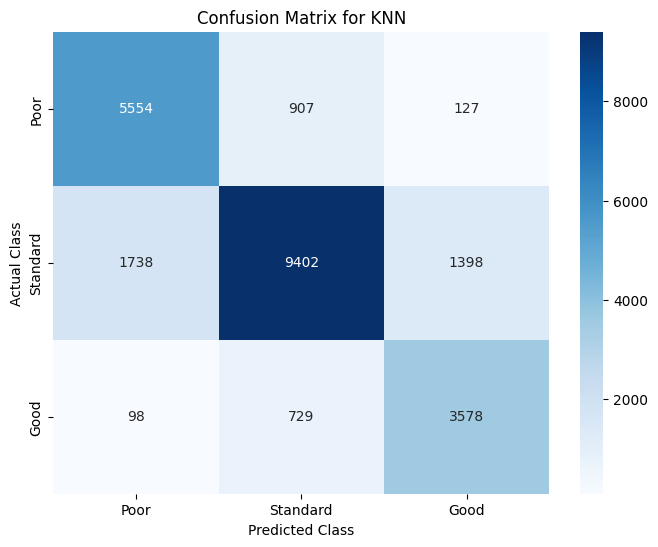

Classification Report for KNN:
              precision    recall  f1-score   support

        Poor       0.75      0.84      0.79      6588
    Standard       0.85      0.75      0.80     12538
        Good       0.70      0.81      0.75      4405

    accuracy                           0.79     23531
   macro avg       0.77      0.80      0.78     23531
weighted avg       0.80      0.79      0.79     23531

Evaluating Logistic Regression...


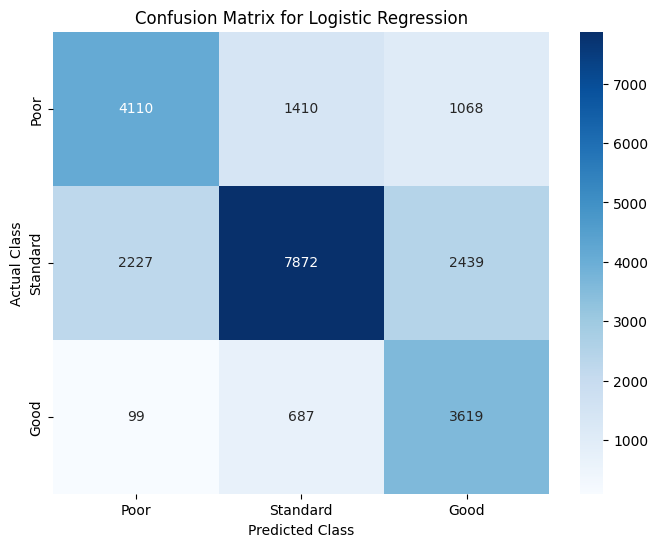

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Poor       0.64      0.62      0.63      6588
    Standard       0.79      0.63      0.70     12538
        Good       0.51      0.82      0.63      4405

    accuracy                           0.66     23531
   macro avg       0.65      0.69      0.65     23531
weighted avg       0.69      0.66      0.67     23531

Evaluating Random Forest...


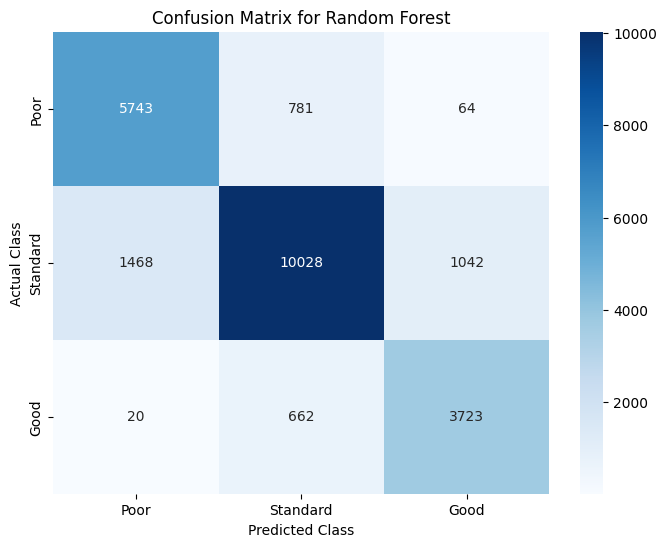

Classification Report for Random Forest:
              precision    recall  f1-score   support

        Poor       0.79      0.87      0.83      6588
    Standard       0.87      0.80      0.84     12538
        Good       0.77      0.85      0.81      4405

    accuracy                           0.83     23531
   macro avg       0.81      0.84      0.82     23531
weighted avg       0.83      0.83      0.83     23531

Evaluating Extra Trees...


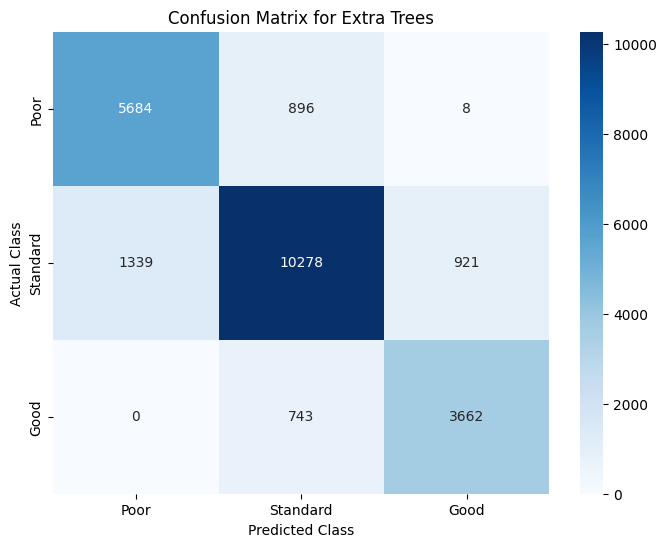

Classification Report for Extra Trees:
              precision    recall  f1-score   support

        Poor       0.81      0.86      0.84      6588
    Standard       0.86      0.82      0.84     12538
        Good       0.80      0.83      0.81      4405

    accuracy                           0.83     23531
   macro avg       0.82      0.84      0.83     23531
weighted avg       0.84      0.83      0.83     23531

Evaluating AdaBoost...


/Users/rahuldev/miniforge3/envs/big_data/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


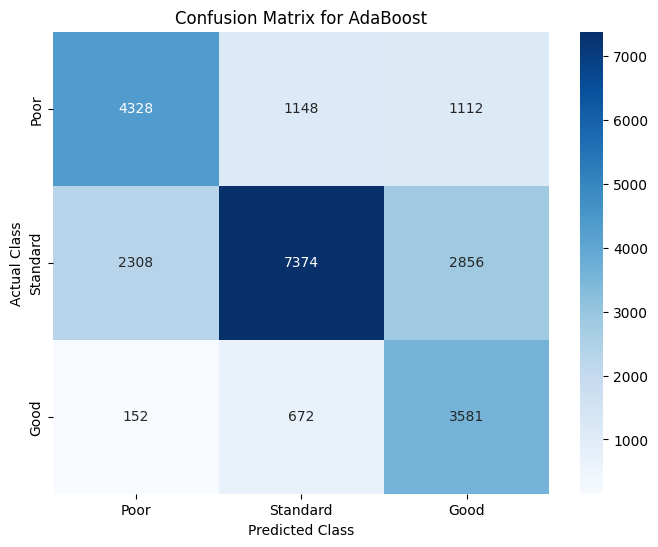

Classification Report for AdaBoost:
              precision    recall  f1-score   support

        Poor       0.64      0.66      0.65      6588
    Standard       0.80      0.59      0.68     12538
        Good       0.47      0.81      0.60      4405

    accuracy                           0.65     23531
   macro avg       0.64      0.69      0.64     23531
weighted avg       0.69      0.65      0.65     23531

Evaluating Gradient Boosting...


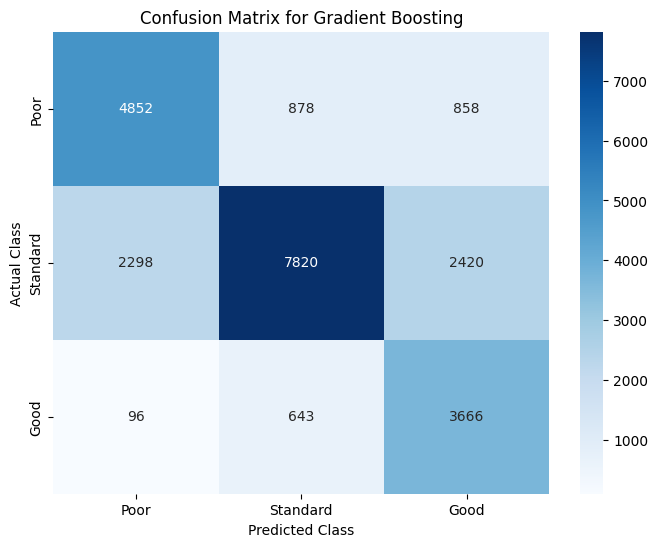

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

        Poor       0.67      0.74      0.70      6588
    Standard       0.84      0.62      0.71     12538
        Good       0.53      0.83      0.65      4405

    accuracy                           0.69     23531
   macro avg       0.68      0.73      0.69     23531
weighted avg       0.73      0.69      0.70     23531



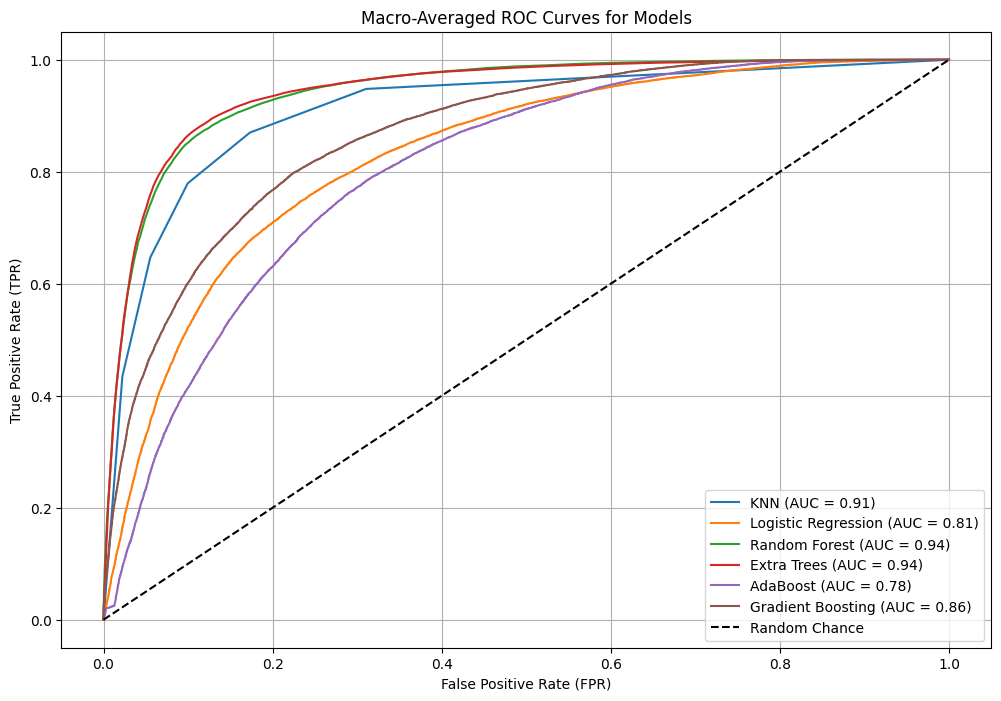

In [9]:
# Step 5: Define Models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Step 6: Train and Evaluate Models
model_results = {}
roc_data = {}
y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding for ROC

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
    model_results[model_name] = report

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.savefig(f"SMOTE Confusion Matrix - {model_name}.png", dpi=300)
    plt.show()
    plt.close()

    # Macro-Averaged AUC-ROC
    macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    roc_data[model_name] = {"probabilities": y_prob, "macro_auc": macro_auc}

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=classes))

# Step 7: Plot Macro-Averaged ROC Curves
plt.figure(figsize=(12, 8))
for model_name, data in roc_data.items():
    y_prob = data['probabilities']
    macro_auc = data['macro_auc']
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {macro_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Macro-Averaged ROC Curves for Models")
plt.legend()
plt.grid()
plt.savefig("SMOTE Macro_Averaged_ROC_Curves.png", dpi=300)
plt.show()
plt.close()



In [10]:
# Step 8: Identify Best Model for "Poor" Class
best_model_name = None
best_poor_f1 = 0
best_poor_recall = 0

for model_name, report in model_results.items():
    poor_f1 = report['Poor']['f1-score']
    poor_recall = report['Poor']['recall']
    print(f"{model_name} - F1 (Poor): {poor_f1:.2f}, Recall (Poor): {poor_recall:.2f}")

    if poor_f1 > best_poor_f1 or (poor_f1 == best_poor_f1 and poor_recall > best_poor_recall):
        best_poor_f1 = poor_f1
        best_poor_recall = poor_recall
        best_model_name = model_name

print(f"\nBest Model for 'Poor': {best_model_name} with F1 = {best_poor_f1:.2f}, Recall = {best_poor_recall:.2f}")


KNN - F1 (Poor): 0.79, Recall (Poor): 0.84
Logistic Regression - F1 (Poor): 0.63, Recall (Poor): 0.62
Random Forest - F1 (Poor): 0.83, Recall (Poor): 0.87
Extra Trees - F1 (Poor): 0.84, Recall (Poor): 0.86
AdaBoost - F1 (Poor): 0.65, Recall (Poor): 0.66
Gradient Boosting - F1 (Poor): 0.70, Recall (Poor): 0.74

Best Model for 'Poor': Extra Trees with F1 = 0.84, Recall = 0.86


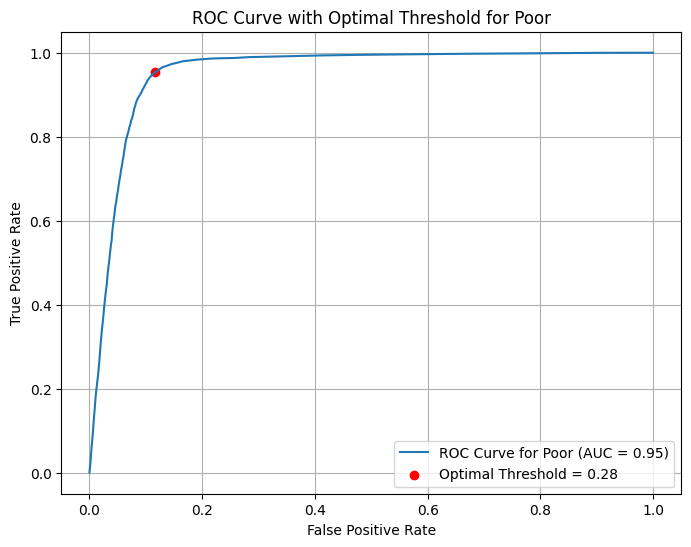

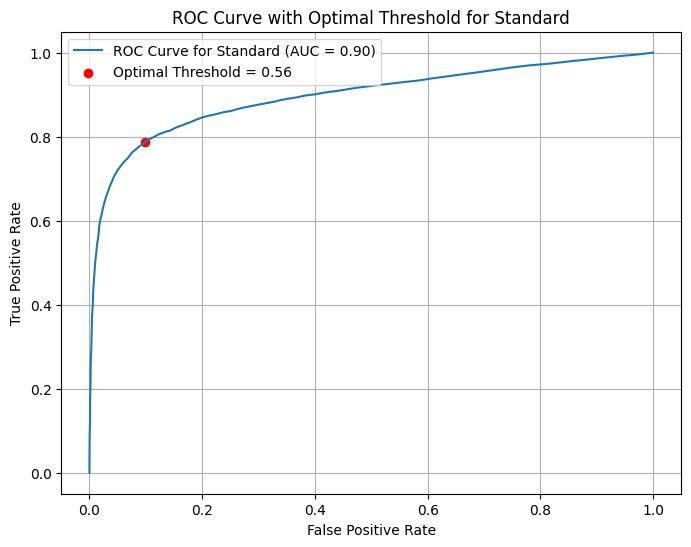

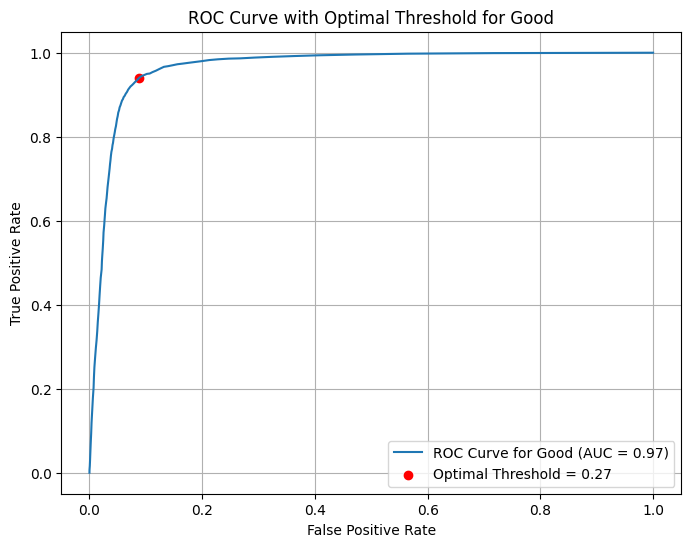

Optimal Thresholds for Each Class: {'Poor': np.float64(0.28), 'Standard': np.float64(0.56), 'Good': np.float64(0.27)}
Classification Report (After Threshold Tuning):
              precision    recall  f1-score   support

        Poor       0.78      0.93      0.85      6588
    Standard       0.93      0.75      0.83     12538
        Good       0.75      0.92      0.82      4405

    accuracy                           0.84     23531
   macro avg       0.82      0.87      0.83     23531
weighted avg       0.85      0.84      0.84     23531



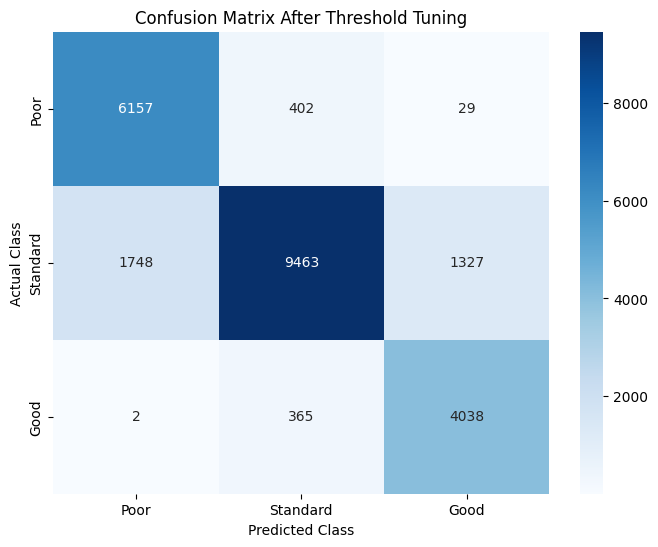

In [11]:
# Step 9: Per-Class Threshold Tuning for Best Model
best_model = models[best_model_name]
y_prob = best_model.predict_proba(X_test_scaled)

optimal_thresholds = {}
for i, cls in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_prob[:, i])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[cls] = optimal_threshold

    # Plot ROC curve with optimal threshold
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve for {cls} (AUC = {roc_auc_score(y_test_bin[:, i], y_prob[:, i]):.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve with Optimal Threshold for {cls}')
    plt.legend()
    plt.grid()
    plt.savefig(f"SMOTE ROC Curve - {cls} (Best Model).png", dpi=300)
    plt.show()
    plt.close()

print("Optimal Thresholds for Each Class:", optimal_thresholds)

# Step 10: Apply Tuned Thresholds and Evaluate
y_pred_tuned = []
for i in range(len(X_test_scaled)):
    class_probs = y_prob[i]
    adjusted_probs = [class_probs[cls_idx] - optimal_thresholds[cls] for cls_idx, cls in enumerate(classes)]
    assigned_class = np.argmax(adjusted_probs)
    y_pred_tuned.append(assigned_class)

print("Classification Report (After Threshold Tuning):")
print(classification_report(y_test, y_pred_tuned, target_names=classes))

cm = confusion_matrix(y_test, y_pred_tuned, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix After Threshold Tuning")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.savefig("SMOTE Confusion Matrix After Threshold Tuning.png", dpi=300)
plt.show()
plt.close()
